<a href="https://colab.research.google.com/github/doissegundos/Pesquisa_Evasao_Ingressantes_EngenhariaComput/blob/main/Visualiza_Dados_Ingressantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Roteiro de Análise dos Dados de Ingressantes 2020.1

## PET-CEC (Outubro/2020)
## Análise do sentimento de evasão dos alunos ativos

variavel proxy*

    
                    "Se você torturar os dados o bastantes, cedo ou tarde eles vão confessar."
                                                                       ditado estatístico.

# 1.Funções importantes para formatação dos gráficos


In [ ]:
"""
    Função para plotar um gráfico com dados que havia ';'
"""
def tirar_o_separador(base,texto):
  # base - base de dados 
  # texto - nome da coluna de interesse na base de dados


  # Atribui apenas a coluna de interesse
  a = base[texto]

  # Cria um Data Frame
  df_fatores = pd.DataFrame(columns={'Fatores'})
  
  # Dividir cada amostras a partir do separador ';'
  for i in a:
    aux = i.split(';')
    for j in aux:
      df_fatores = df_fatores.append({'Fatores':j}, ignore_index=True)

  # Plota o histograma
  fig = px.histogram(df_fatores,
                    x='Fatores',
                    title='Quais os fatores que influenciaram na escolha do curso?',
                    labels={'Fatores':''},
                    nbins=11).update_xaxes(categoryorder='total descending')
  fig.show()

""" 
  Função para plotarr um histograma usando o matplotlib mas para os eixos
  invertidos. Não consegui inverter os eixos com plotly.
"""
def plot_histograma_horizontal(base,texto):
  # base - base de dados
  # texto - nome da coluna da base de dados

  # Atribui apenas a coluna de interesse
  df_aux_dificuldade = base[texto]

  # Ciclo for para povoar um vetor com os dados separados
  df_aux_2 = []
  for i in df_aux_dificuldade:
    splits = i.split(';')
    for j in splits:
      df_aux_2.append(j)

  # Atribui os dados do vetor em um data frame      
  df_dificuldades = pd.DataFrame(columns={'Metodo'},data=df_aux_2)

  # Plota o histograma com os eixos invertidos
  x = [i[0] for i in df_dificuldades.value_counts().sort_values().index]
  y = df_dificuldades.value_counts().sort_values().values
  plt.figure(figsize=(20,10))
  ax = plt.barh(x,y)
  ax = plt.yticks(fontsize=20)
  ax = plt.xticks(fontsize=20)

  plt.show()

def find_best_params(X,y):
    espaco_de_parametros = {
                            "criterion"         : ["gini","entropy"],
                            "splitter"          : ["best","random"],
                            "max_depth"         : [3,5,20,25,50,100,150],
                            "min_samples_split" : [3,5,20,25,50,100,150],
                            "min_samples_leaf"  : [3,5,30,50,100,150]
                           }

    modelos = GridSearchCV(DecisionTreeClassifier(),
                           espaco_de_parametros,
                           cv=KFold(n_splits=15,shuffle=True))
    modelos.fit(X,y)
    
    print('-------Best escore-------')
    print(f'>>>> {modelos.best_score_}')
    
    print('\n-------Best Params-------\n')
    print(f'{modelos.best_params_}')
  
    print('\n--------Feature importance--------\n')
    modelo = modelos.best_params_
    arvore = DecisionTreeClassifier(criterion=modelo['criterion'],
                                    max_depth=modelo['max_depth'],
                                    min_samples_leaf=modelo['min_samples_leaf'],
                                    min_samples_split=modelo['min_samples_split'],
                                    splitter=modelo['splitter'])
    arvore.fit(X,y)
    dic = {i:arvore.feature_importances_[v] for v,i in enumerate(X.columns)}
    f_importances = pd.DataFrame(list(dic.items()),
                 columns=['feature', 'importance']).sort_values(by='importance',
                                                                ascending=False)
    display(f_importances)

    return modelos.best_params_,f_importances

def renomar_valores(base):
  for count in range(base.columns.shape[0]):
    base.iloc[:,count].replace(
            {i:j+1 for i,j in zip(base.iloc[:,count].unique(),range(base.iloc[:,count].unique().shape[0]))},
            inplace=True)
  return base    

# 2.Import necessários

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
import plotly.figure_factory as ff
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab import drive
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd
import graphviz
import warnings
warnings.filterwarnings('ignore')
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# 3.Upload da base de dados
Fiz um repo no meu github para facilitar o upload da base de dados, como é pequena (<25Mb) podemos colocar no github. Porém temos outras opções como usar o mesmo procedimento com o bitbucket, pois ele armazena mais. Também, podemos usar o AWS ou heroku e junto com gunicorn API para fazer um servidor.

In [ ]:
dados_evasao = pd.read_csv('https://raw.githubusercontent.com/SamuelHericles/evsao_csv/main/Pesquisa%20sobre%20Evas%C3%A3o%20no%20Curso-Ingressantes.csv')
dados_evasao.columns

Index(['Carimbo de data/hora', 'Qual sua idade?',
       'Você tinha como primeira opção o curso de Engenharia da Computação para entrar na universidade?',
       'Quais os fatores que influenciaram na escolha do curso?',
       'Em sua rotina pessoal, você é o responsável de alguma pessoa?',
       'Você possui alguma outra ocupação (trabalho, atividade doméstica, etc) além dos estudos?',
       'Se respondeu sim na questão anterior, poderia informar se a área de atuação da sua ocupação está relacionada com o curso?',
       'Quantos membros da sua família já ingressaram na universidade? (envolvendo pessoas que estão próximas à sua vivência)',
       'Como você classificaria sua afinidade com a matemática?',
       'Qual seu nível de concordância em relação à seguinte frase: "Estou bem fundamentado em ciências básicas para cursar Engenharia da Computação."',
       'Você mora na cidade em Sobral?',
       'Se você não mora em Sobral, com que frequência você volta para sua cidade?',
  

# 4.Plotagem de histogramas das respostas dos usuários
Alguns dele está mau formatados, ou melhor, os labels dos eixos x estão muito grandes e também algumas amostras possuem mais de um dentro dela separadas por ';'. Com isso há uma subsessão que tem o tratamento dela.

In [ ]:
for i in dados_evasao.columns[1:-2]:
  fig = px.histogram(dados_evasao[str(i)],
                     x=i, # Coluna de interesse
                     title=i, # O titulo do gráfico é o próprio nome da coluna
                     labels={
                         "sepal_length": "Sepal Length (cm)",
                         "sepal_width": "Sepal Width (cm)"}, # Retira o nome da coluna com legenda do eixos x
                     nbins=20).update_xaxes(categoryorder='total descending')
  fig.show()

# 4.1 Tratamento de histograma mal formatados



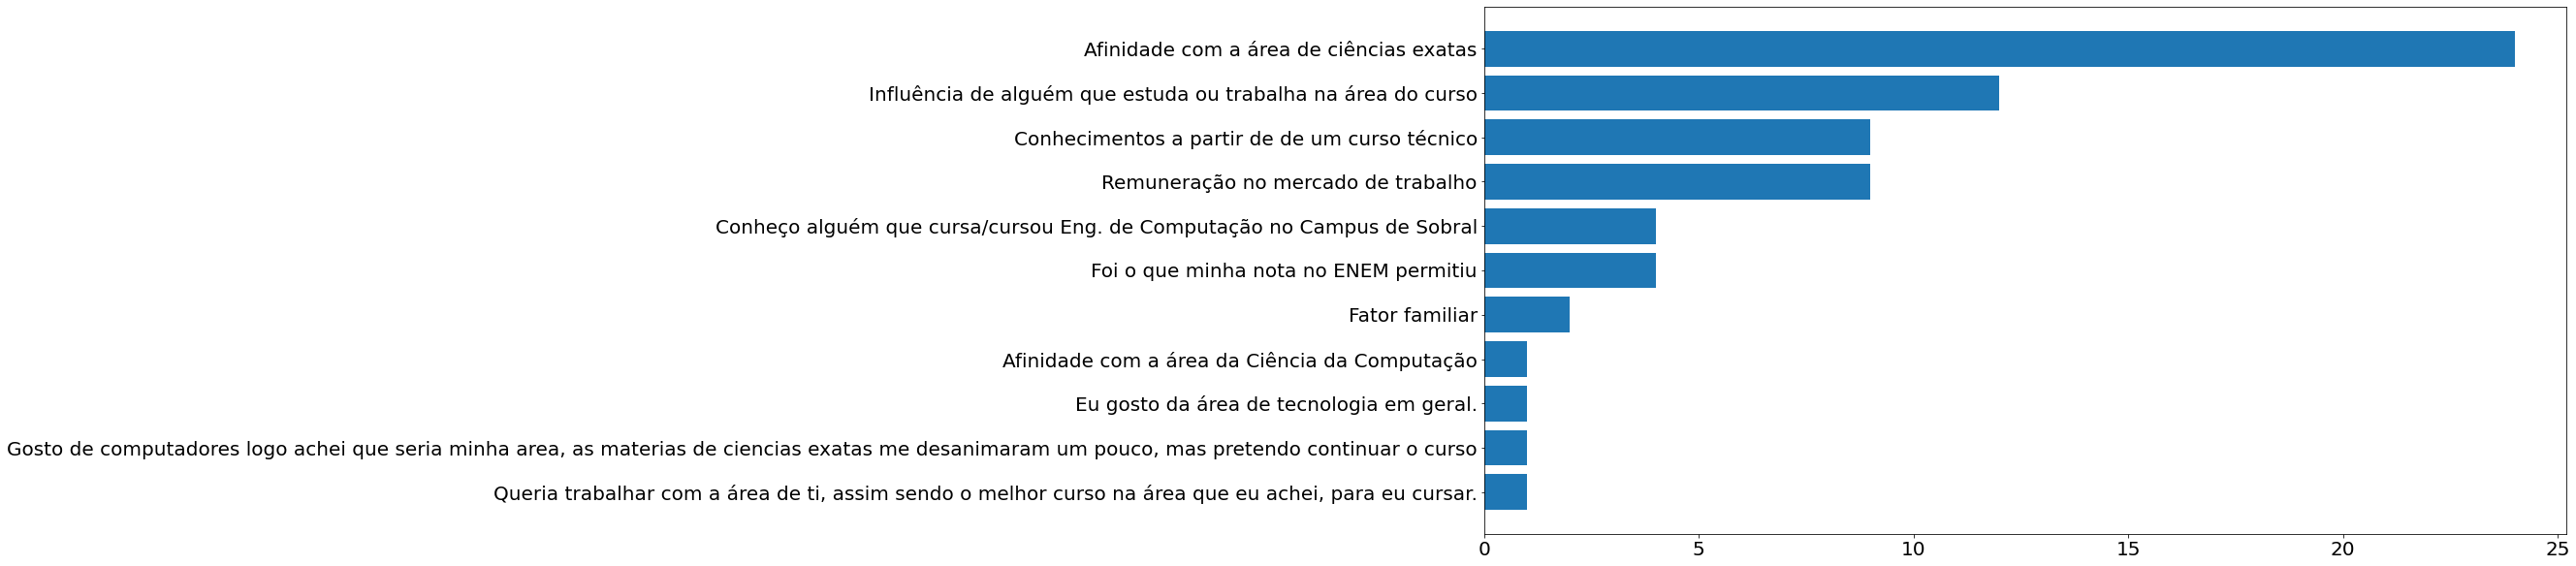

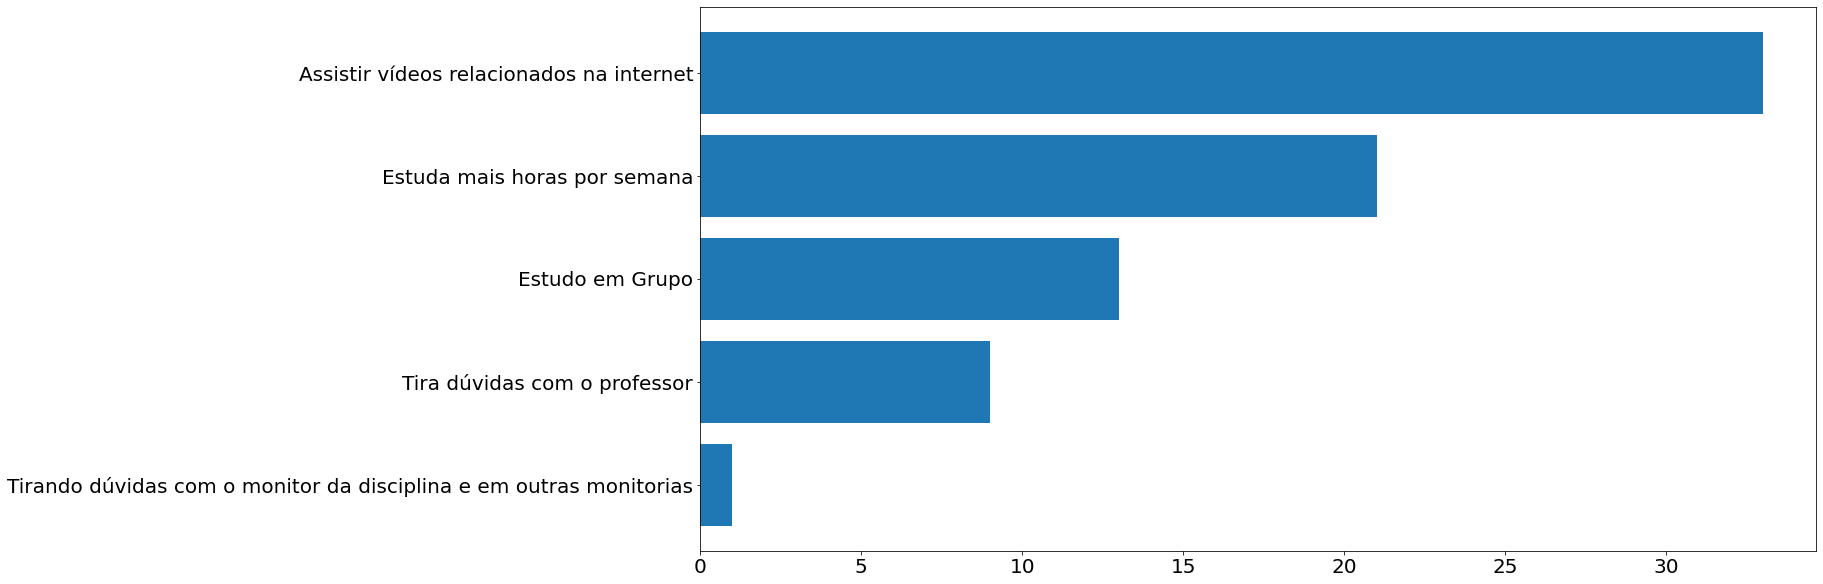

In [ ]:
tirar_o_separador(dados_evasao,'Quais os fatores que influenciaram na escolha do curso?')
plot_histograma_horizontal(dados_evasao,'Quais os fatores que influenciaram na escolha do curso?')
tirar_o_separador(dados_evasao,'Quais as disciplinas você considera ter maior grau de dificuldade de aprendizagem?')
tirar_o_separador(dados_evasao,'Quando você sente dificuldade em um conteúdo quais medidas faz para superá-las?')
plot_histograma_horizontal(dados_evasao,'Quando você sente dificuldade em um conteúdo quais medidas faz para superá-las?')

# 5.Feature importance

In [ ]:
df = dados_evasao.iloc[:,1:-2]

# data-augemation simples
a = pd.concat([df,df,df])

X = a.iloc[:,1:]
y = a.iloc[:,0]

for count in range(X.columns.shape[0]):
  X.iloc[:,count].replace(
          {i:j+1 for i,j in zip(X.iloc[:,count].unique(),range(X.iloc[:,count].unique().shape[0]))},
          inplace=True)
    
modelo,f_importances = find_best_params(X,y)

-------Best escore-------
>>>> 0.8412698412698413

-------Best Params-------

{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 3, 'min_samples_split': 3, 'splitter': 'random'}

--------Feature importance--------



,feature,importance
55,Dos serviços e iniciativas disponíveis no Camp...,0.267302
18,Quais as disciplinas você considera ter maior ...,0.227946
9,"Se você não mora em Sobral, com que frequência...",0.114021
16,"""Estudo em grupo pode elevar o desempenho dos ...",0.108467
37,"O quanto você concorda com essa afirmação: ""Pr...",0.091972
...,...,...
29,"Antes de ingressar no curso, você pesquisou pe...",0.000000
30,Você já cursou outro curso de graduação?,0.000000
31,"Se respondeu sim à questão anterior, o outro c...",0.000000
1,Quais os fatores que influenciaram na escolha ...,0.000000


# 5.1 Plotar árvore de descisão de clasificação
Tentei encontrar alguma coisa aqui, mas nada, para mim.


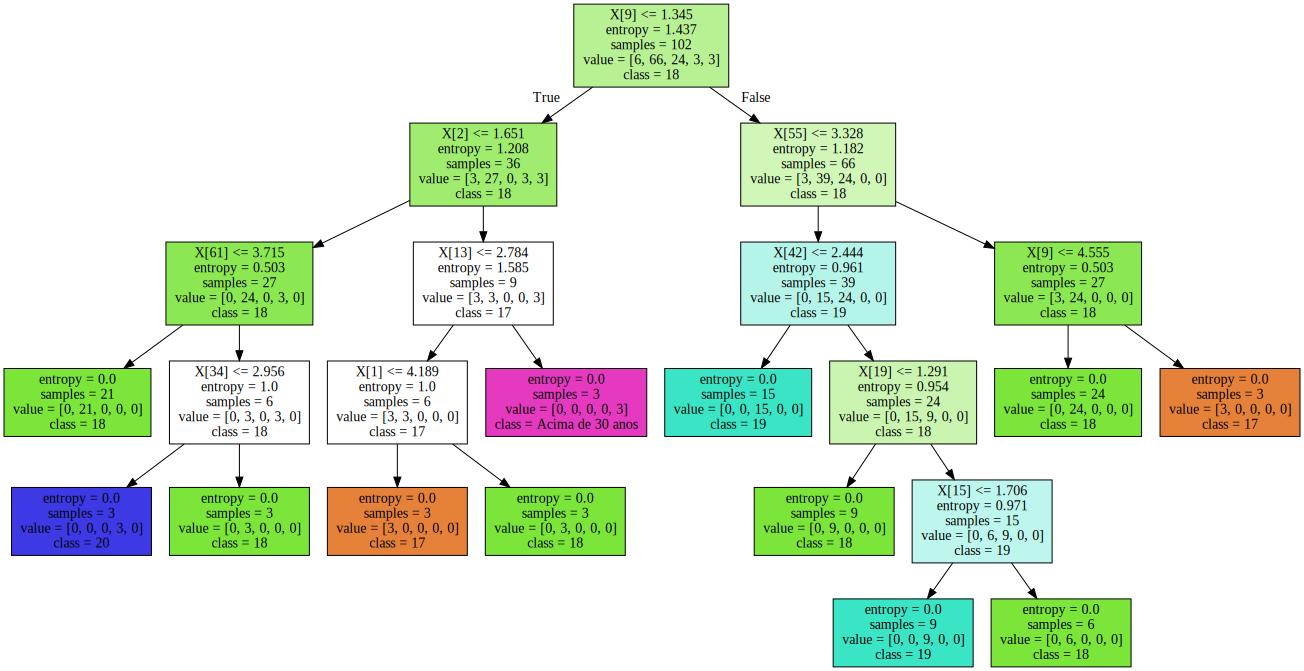

In [ ]:
arvore = DecisionTreeClassifier(criterion=modelo['criterion'],
                                max_depth=modelo['max_depth'],
                                min_samples_leaf=modelo['min_samples_leaf'],
                                min_samples_split=modelo['min_samples_split'],
                                splitter=modelo['splitter'],random_state=42)
arvore.fit(X,y)

dot_data = export_graphviz(arvore,
                          out_file = None,
                           class_names= sorted(y.unique()),
                           filled = True)
graph = graphviz.Source(dot_data)
graph

# 6.Dendograma


In [ ]:
a = df_count.columns
type(list(a))

list

In [ ]:
df_count = renomar_valores(dados_evasao.iloc[:,1:-2])
aux = dados_evasao.iloc[:,1]
aux.replace({'Acima de 30 anos':31},inplace=True)
df_count['idade'] = aux

fig = ff.create_dendrogram(df_count,hovertext=list(a))

img_width = 1800
img_height = 900

fig.update_layout(
    width=img_width,
    height=img_height)

fig.show()

# 7.Clusterização com Kmeans

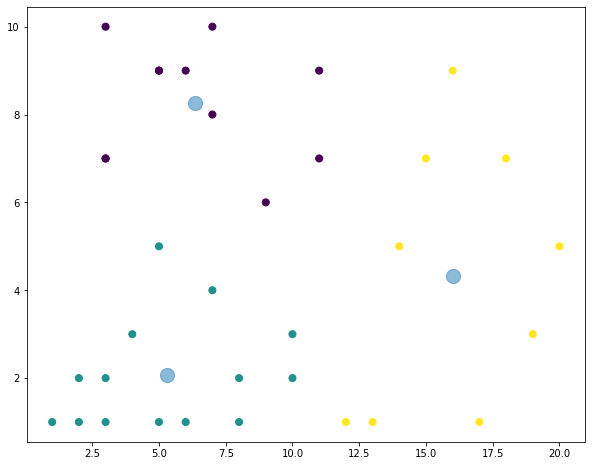

In [ ]:
kmeans = KMeans(init='random',
                max_iter= 200,
                n_clusters=3,
                n_init= 50).fit(df_count.iloc[:,[2,18]])

y_kmeans = kmeans.predict(df_count.iloc[:,[2,18]])
centers = kmeans.cluster_centers_

plt.figure(figsize=(10,8))
plt.scatter(df_count.iloc[:,2],df_count.iloc[:,18], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0],centers[:, 1], s=200, alpha=0.5)
plt.show()